# Understanding the network through visualizations
During the training process, our models learn two things that allow it to generate the pseudo words. First, it creates a relevant embedded representation of the "vocabulary", the language's characters. Second, by leveraging these representations, it can generate an abstraction, a "memory", of the previously seen characters to create patterns which we ultimately analyze as syllables and plausible words. In this section, we will create visualizations of these two phenomenon to show that deep learning is not an absolute black box.

## 1 How characters relate to each other
The first layer of how model is an embedding layer, it contains the key to turn a character index into arrays of numbers, which is called embedding. We also need our tokenizer, which is a simple dictionary mapping the characters of our training dataset to their aforementioned indices.

In [124]:
import torch.nn as nn

# 0: redeclare the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layers_number, char_to_idx, idx_to_char):
        super().__init__()
        self.char_to_idx = char_to_idx
        self.idx_to_char = idx_to_char
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layers_number, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size=1):
        return (torch.zeros(layers_number, batch_size , hidden_dim),
                torch.zeros(layers_number, batch_size , hidden_dim))

# 1: load the model from the previous chapter
locale = "en-GB" # Change this variable if necessary
model = torch.load(f'locales/{locale}/lstm_model-{locale}.pth')

# 2: extract the embedding layer and its associated characters
chars = [n if n != "\n" else "\\n" for n in model.idx_to_char.values()]
embedding = model.embedding.weight.numpy()
print(embedding)

[[-15.902132     6.670161    11.273422    14.89657   ]
 [  1.0068086    1.9431105   -1.3776059    0.6839143 ]
 [  1.7012677   -1.2399778    1.1160897    2.088244  ]
 [ -1.3483042   -1.2167956    0.03574739   2.437032  ]
 [  1.5413256   -2.0062807    0.44377208  -0.95148903]
 [  0.08625892   1.0935781    0.9979747   -1.0987356 ]
 [  3.4167118   -1.566905     0.5275117    2.2893918 ]
 [  1.9804773   -0.49524686  -0.5244674    0.40125948]
 [  2.1585763   -2.1670105    0.40419567  -0.19569464]
 [ -0.73627883   1.494374    -1.7228925   -0.26137075]
 [ -0.6288716    0.99386424  -1.7217155    3.7553582 ]
 [  3.7449398   -1.5250738   -0.24596752  -1.1093782 ]
 [  0.46885014  -3.4760604    0.30994034   0.8260559 ]
 [  0.44931948  -1.887174     1.6343986    1.0263537 ]
 [ -0.34964025  -0.59956765  -1.929508     1.218788  ]
 [ -0.5577897    0.1739808   -0.6713699   -2.0965972 ]
 [  0.7204599   -0.42141357   0.7031446    1.9503556 ]
 [-14.630714    -0.2522387   -1.9123989   13.893532  ]
 [ -0.6391

Now we will use the library scikit-learn's T-distributed Stochastic Neighbor Embedding (t-SNE) to do reduce the dimensionalities of the vectorial representation of the embedded characters. In our original model, the characters are represented in a 16 dimensional space, but to show how close the characters are associated to one another during the training process, we only need two dimensions.

In [53]:
%pip install scikit-learn numpy seaborn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


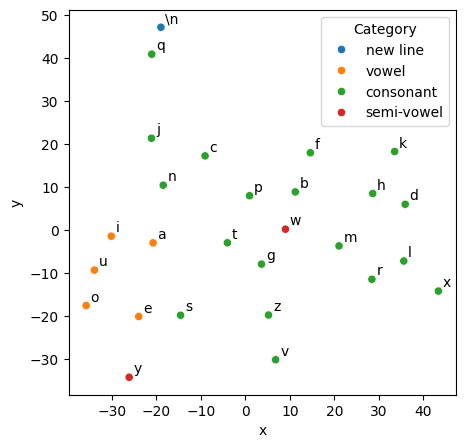

In [168]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = np.array(embedding)
reduced_embedding = PCA(n_components=2).fit_transform(TSNE(n_components=2, perplexity=8).fit_transform(X))

df = pd.DataFrame(reduced_embedding, columns=["x", "y"])
df["chars"] = chars
df["Category"] = ["vowel" if c in "aeiou" else "semi-vowel" if c in "yw" else "new line" if c == "\\n" else "consonant" for c in chars]

plt.figure(figsize=(5, 5))
sns.scatterplot(x="x", y="y", data=df, hue="Category")

for i in range(len(chars)):
    plt.annotate(df["chars"][i], (df["x"][i]+1, df["y"][i]+1))

plt.show()
# 3 use scikit learn to do TSNE dimensionality reduction
# 4 train a Ukrainian model and compare the results

## 2 Inspecting the memory of an LSTM cell
This section is inspired by this [Andrej Karpathy's article](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [ ]:
# 1 create a function that generated a word
# 2 have the function return a matrix of the successive hidden states along with the word
# 3 create a second function that builds a heatmap for the first index of the matrix
# 4 loop the function to optain a heatmap for all indices of the matrix